In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics import accuracy_score

### 1. Préparation des données

In [6]:
df_data = pd.read_csv('../data/train.csv')
df_data.head(1)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


In [7]:
X = df_data.copy().drop(['id', 'species'],axis='columns').values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros(df_data.shape[0])
for i in range(species.size):
    t[df_data['species'] == species[i]] = i

In [8]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [24]:
#création des listes des valeurs d'hyper-paramètres possibles et choix du maximum d'itérations
all_values_lr = np.logspace(-9, 0, 10)
all_values_alpha = np.logspace(-9, 0, 10)
max_iter = 100000

### 2. Perceptron sans optimisation de paramètres

In [18]:
alpha = 0.001
learning_rate = 0.001

# création d'un classifieur binaire pour chaque classe
classifieur = Perceptron(alpha=alpha, max_iter=max_iter, eta0=learning_rate)    
classifieur.fit(X_train, t_train)

Perceptron(alpha=0.01, eta0=0.01, max_iter=100000)

In [19]:
classifieur.score(X_train, t_train)

0.45021645021645024

# 3. Perceptron avec optimisation des paramètres

In [33]:
# Paramètre à tester
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Création du modèle de recherche sur grille
grid_search_perceptron = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=10, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_perceptron.fit(X_train, t_train)
print('Done')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Done


In [34]:
results_grid_perceptron = pd.DataFrame.from_dict(grid_search_perceptron.cv_results_)
print(results_grid_perceptron)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.402494      0.107692         0.004291        0.004121         0.0   
1        0.390179      0.132962         0.001517        0.000460         0.0   
2        0.484431      0.113045         0.001806        0.000535         0.0   
3        0.400728      0.075741         0.001807        0.000822         0.0   
4        0.343378      0.049784         0.002304        0.001941         0.0   
..            ...           ...              ...             ...         ...   
95       0.453362      0.074192         0.001711        0.000731         1.0   
96       0.320504      0.069533         0.002147        0.001990         1.0   
97       0.316040      0.068444         0.001464        0.000488         1.0   
98       0.297345      0.066327         0.001854        0.000526         1.0   
99       0.371853      0.045181         0.002394        0.000885         1.0   

   param_eta0                          

In [35]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_perceptron.best_params_)
print("Meilleure précision:", grid_search_perceptron.best_score_)

Meilleur paramètre: {'alpha': 1e-06, 'eta0': 1.0}
Meilleure précision: 0.7304347826086955


In [40]:
print('Score : ',grid_search_perceptron.score(X_train,t_train))

Score :  0.84992784992785


### 4. Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

In [78]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize = (8,6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=10, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=10)
    ax.set_ylabel('CV Average Score', fontsize=10)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    ax.grid('on') 


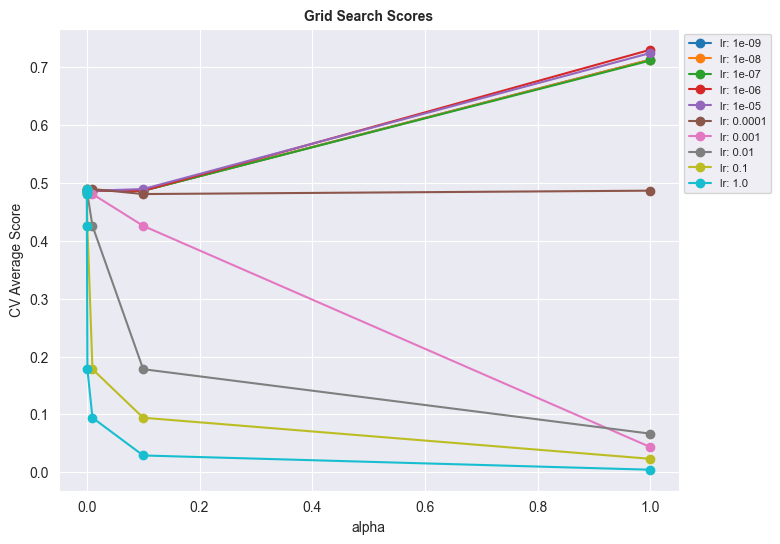

In [84]:
plot_grid_search(results_grid_perceptron, all_values_alpha, all_values_lr, 'alpha', 'lr')

# 5. Visualisation de notre apprentissage sous UMAP

Précision du modèle sur l'ensemble d'entraînement : 0.85


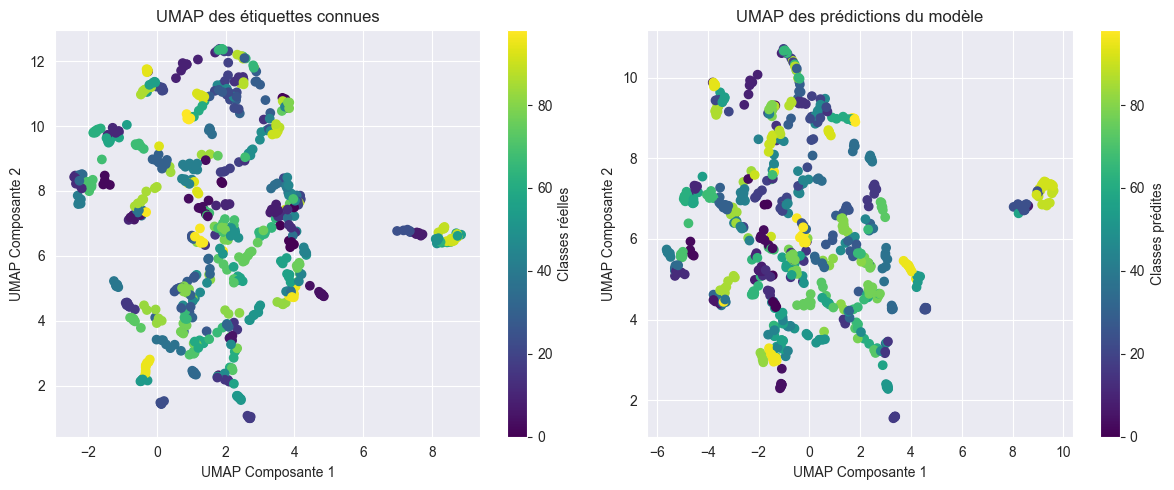

In [81]:
# Réduire la dimensionnalité à 2 avec UMAP pour les étiquettes connues
umap_model_labels = UMAP(n_components=2)
X_train_umap_labels = umap_model_labels.fit_transform(X_train)

# Prédire les classes pour l'ensemble de train
t_pred = grid_search_perceptron.predict(X_train)
accuracy = accuracy_score(t_train, t_pred)
print(f"Précision du modèle sur l'ensemble d'entraînement : {accuracy:.2f}")

umap_model_predictions = UMAP(n_components=2)
X_train_umap_predictions = umap_model_predictions.fit_transform(X_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter_umap_labels = plt.scatter(X_train_umap_labels[:, 0], X_train_umap_labels[:, 1], c=t_train, cmap='viridis')
plt.title('UMAP des étiquettes connues')
plt.xlabel('UMAP Composante 1')
plt.ylabel('UMAP Composante 2')
plt.colorbar(scatter_umap_labels, label='Classes réelles')

plt.subplot(1, 2, 2)
scatter_umap_predictions = plt.scatter(X_train_umap_predictions[:, 0], X_train_umap_predictions[:, 1], c=t_pred, cmap='viridis')
plt.title('UMAP des prédictions du modèle')
plt.xlabel('UMAP Composante 1')
plt.ylabel('UMAP Composante 2')
plt.colorbar(scatter_umap_predictions, label='Classes prédites')

plt.tight_layout()
plt.show()

### 6. Test du perceptron sur nos données test

In [85]:
print('Résultat sur nos données test : ',grid_search_perceptron.score(X_test,t_test))

Résultat sur nos données test :  0.632996632996633


In [88]:
t_pred = grid_search_perceptron.predict(X_test)
accuracy = accuracy_score(t_test, t_pred)
print(f"Précision du modèle sur l'ensemble de test : {accuracy:.2f}")

Précision du modèle sur l'ensemble de test : 0.63


### 7. Visualisation du résultats du perceptron sur les données test sous UMAP

Précision du modèle sur l'ensemble de test : 0.63


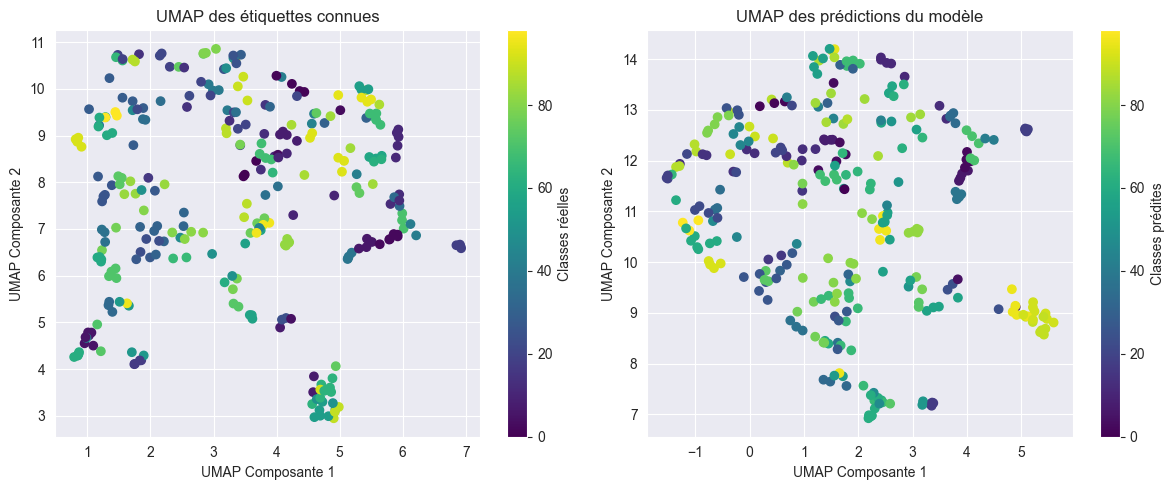

In [83]:
# Réduire la dimensionnalité à 2 avec UMAP pour les étiquettes connues
umap_model_labels = UMAP(n_components=2)
X_test_umap_labels = umap_model_labels.fit_transform(X_test)

# Prédire les classes pour l'ensemble de train
t_pred = grid_search_perceptron.predict(X_test)
accuracy = accuracy_score(t_test, t_pred)
print(f"Précision du modèle sur l'ensemble de test : {accuracy:.2f}")

umap_model_predictions = UMAP(n_components=2)
X_test_umap_predictions = umap_model_predictions.fit_transform(X_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter_umap_labels = plt.scatter(X_test_umap_labels[:, 0], X_test_umap_labels[:, 1], c=t_test, cmap='viridis')
plt.title('UMAP des étiquettes connues')
plt.xlabel('UMAP Composante 1')
plt.ylabel('UMAP Composante 2')
plt.colorbar(scatter_umap_labels, label='Classes réelles')

plt.subplot(1, 2, 2)
scatter_umap_predictions = plt.scatter(X_test_umap_predictions[:, 0], X_test_umap_predictions[:, 1], c=t_pred, cmap='viridis')
plt.title('UMAP des prédictions du modèle')
plt.xlabel('UMAP Composante 1')
plt.ylabel('UMAP Composante 2')
plt.colorbar(scatter_umap_predictions, label='Classes prédites')

plt.tight_layout()
plt.show()